In [6]:
import numpy as np
import tensorflow as tf
import tensorflow.keras.datasets.mnist as mnist
import matplotlib.pyplot as plt
%matplotlib inline
np.set_printoptions(3)

# Digit Recognition with TensorFlow

In this notebook we will use neural network with fully connected layers to recognize hand-written digits, provided by the [MNIST-Database](https://en.wikipedia.org/wiki/MNIST_database).

### loading & pre-processing data

In [3]:
(trainX, trainY), (testX, testY) = mnist.load_data()

11490434/11490434 ━━━━━━━━━━━━━━━━━━━━ 6s 0us/step


In [7]:
print(f"trainX shape: {trainX.shape}")
print(f"testX shape: {testX.shape}")
print(f"trainY shape: {trainY.shape}")
print(f"testY shape: {testY.shape}")

trainX shape: (60000, 28, 28)
testX shape: (10000, 28, 28)
trainY shape: (60000,)
testY shape: (10000,)


In [8]:
print(f"trainY label: {trainY}")
print(f"testY label: {testY}")

trainY label: [5 0 4 ... 5 6 8]
testY label: [7 2 1 ... 4 5 6]


In [10]:
#normalize $ flatten data
trainX = (trainX / 255.0).reshape(trainX.shape[0], -1)
testX = (testX / 255.0).reshape(testX.shape[0], -1)

#one-hot target
trainY = tf.keras.utils.to_categorical(trainY)
testY = tf.keras.utils.to_categorical(testY)

Here we divided the train and test data by `255` to normalize it, because mnist dataset are encoded as 8-bit integers (0 - 255). Additionally, it needed to be reshaped from (28, 28) into (28 * 28) i.e., `784` for be an one dimensional vector.
we can also see the train data are labeled from 0 to 9. The neural network will have an output layer with 10 neurons (per digit), thus to fit to the network output, the train label needed to be `one-hot encoded`.

In [12]:
print(f"trainX shape: {trainX.shape}")
print(f"testX shape: {testX.shape}")
print(f"trainY shape: {trainY.shape}")
print(f"testY shape: {testY.shape}")
print(f"trainY label: {trainY[:1]}")
print(f"testY label: {testY[:1]}")

trainX shape: (60000, 784)
testX shape: (10000, 784)
trainY shape: (60000, 10)
testY shape: (10000, 10)
trainY label: [[0. 0. 0. 0. 0. 1. 0. 0. 0. 0.]]
testY label: [[0. 0. 0. 0. 0. 0. 0. 1. 0. 0.]]


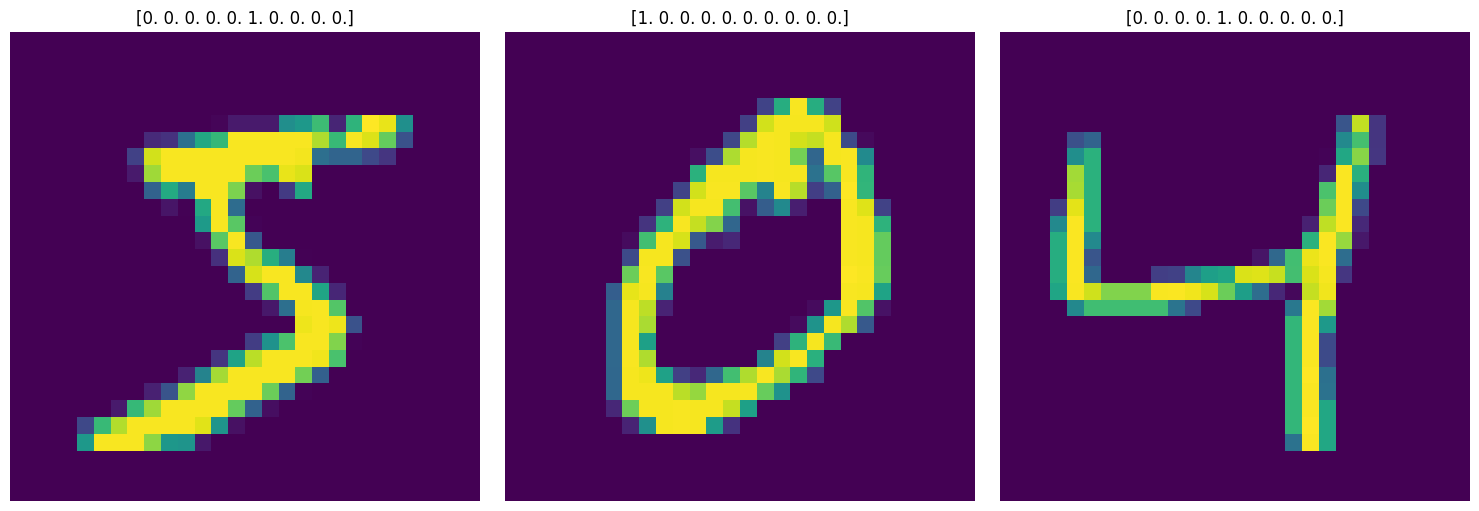

In [18]:
# display the first three examples
fig, axes = plt.subplots(1, 3, figsize=(15, 5))
axes = axes.flatten()
for i, ax in enumerate(axes):
    ax.imshow(trainX[i].reshape(28, 28))
    ax.set_title(trainY[i])
    ax.axis('off')

plt.tight_layout()
plt.show()

### Network design

at first we will implement this model architecture below, later on we might try few more model to check the performance.

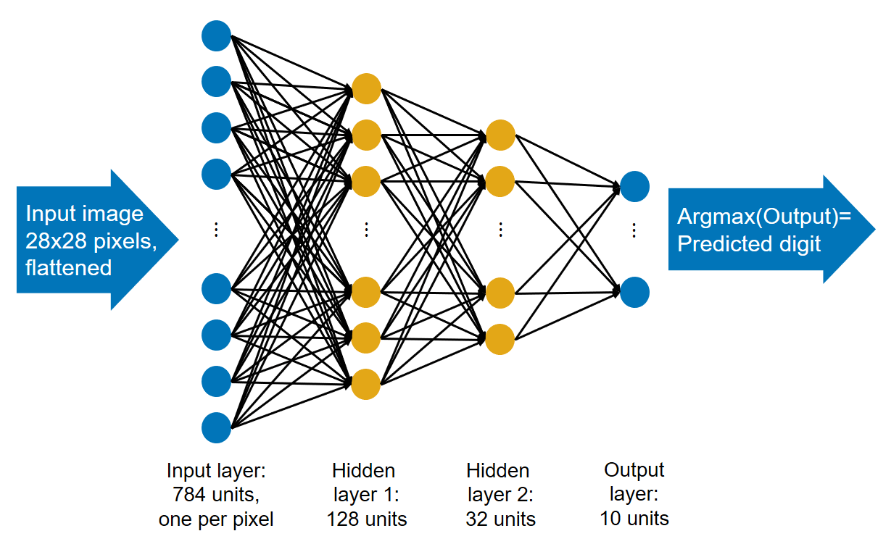

In [20]:
inputs = tf.keras.layers.Input(shape = (trainX.shape[1],))
x = tf.keras.layers.Dense(128,
                         activation = 'relu', name = 'h1',
                         kernel_initializer = tf.keras.initializers.TruncatedNormal(stddev = 0.1),
                         bias_initializer = tf.keras.initializers.TruncatedNormal(stddev = 0.1))(inputs)
x = tf.keras.layers.Dropout(rate = 0.1)(x)
x = tf.keras.layers.Dense(32,
                         activation = 'relu', name = 'h2',
                         kernel_initializer = tf.keras.initializers.TruncatedNormal(stddev = 0.1),
                         bias_initializer = tf.keras.initializers.TruncatedNormal(stddev = 0.1))(x)
x = tf.keras.layers.Dropout(rate = 0.1)(x)
logits = tf.keras.layers.Dense(10,
                              activation = None, name = 'logits',
                              kernel_initializer = tf.keras.initializers.TruncatedNormal(stddev = 0.1),
                              bias_initializer = tf.keras.initializers.TruncatedNormal(stddev = 0.1))(x)
model1 = tf.keras.Model(inputs = inputs, outputs = logits)
model1.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)           │ (None, 784)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ h1 (Dense)                           │ (None, 128)                 │         100,480 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ h2 (Dense)                           │ (None, 32)                  │           4,128 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_2 (Dropout)                  │ (None, 32)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ logits (Dense)                       │ (None, 10)                  │             330 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 104,938 (409.91 KB)

 Trainable params: 104,938 (409.91 KB)

 Non-trainable params: 0 (0.00 B)

In [21]:
optimizer_SGD = tf.keras.optimizers.SGD(learning_rate=1e-3)
cost_CCE = tf.keras.losses.CategoricalCrossentropy(from_logits=True)
model1.compile(optimizer = optimizer_SGD,
              loss = cost_CCE,
              metrics=['accuracy'])

In [ ]:
def get_batches(x, y, batch_size = 128):
    """ Return a generator that yields batches from arrays x and y. """
    n_batches = len(x) // batch_size
    for j in range(0, n_batches * batch_size, batch_size):
        X, Y = x[j: j + batch_size], y[j: j + batch_size]
        yield X, Y

gen = get_batches(trainX, trainY, 128)